# Baseline: Brute-Force k-NN

This notebook establishes baseline performance using exact brute-force k-NN search.

## Metrics
- **Recall@10**: 1.0 (exact search)
- **Query time**: Time per query in milliseconds
- **Build time**: Time to construct index
- **Memory**: Memory footprint in MB

## Datasets
- SIFT-1M (128-dim)
- GIST-1M (960-dim)
- Deep1B-10M (96-dim)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import sys
import json
import os

# Import our custom modules
sys.path.append('..')  # If running from notebooks/ subdirectory
from evaluator import ANNEvaluator
from datasets import DatasetLoader, print_dataset_info

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports successful!")

Imports successful!


## 1. Configuration

In [2]:
# Configuration
K = 10  # Number of nearest neighbors
DATA_DIR = "data"  # Adjust if needed

# Which datasets to evaluate (comment out to skip)
DATASETS = [
    'sift',
    'gist',
    'deep1b'
]

# Subset sizes (None = use full dataset)
N_TRAIN = None  # Use full training set
N_TEST = 1000   # Use 1000 test queries for faster evaluation

# Results directory
RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Configuration:")
print(f"  k = {K}")
print(f"  Datasets: {DATASETS}")
print(f"  Training samples: {N_TRAIN if N_TRAIN else 'all'}")
print(f"  Test queries: {N_TEST if N_TEST else 'all'}")

Configuration:
  k = 10
  Datasets: ['sift', 'gist', 'deep1b']
  Training samples: all
  Test queries: 1000


## 2. Define Baseline KNN Functions

We need two functions for the evaluator:
1. `index_builder`: Builds the KNN index
2. `query_func`: Queries the index

In [3]:
def build_knn_index(X_train, algorithm='brute', metric='euclidean', n_jobs=-1):
    """
    Build KNN index using sklearn.
    
    Args:
        X_train: Training data
        algorithm: 'brute' for exact search, 'ball_tree' or 'kd_tree' for approximate
        metric: Distance metric
        n_jobs: Number of parallel jobs (-1 = all cores)
    
    Returns:
        Fitted NearestNeighbors object
    """
    knn = NearestNeighbors(
        algorithm=algorithm,
        metric=metric,
        n_jobs=n_jobs
    )
    knn.fit(X_train)
    return knn


def query_knn_index(index, X_test, k):
    """
    Query KNN index.
    
    Args:
        index: Fitted NearestNeighbors object
        X_test: Query vectors
        k: Number of neighbors to retrieve
    
    Returns:
        (indices, distances) tuple
    """
    distances, indices = index.kneighbors(X_test, n_neighbors=k)
    return indices, distances


print("KNN functions defined!")

KNN functions defined!


## 3. Run Baseline Experiments

We'll evaluate brute-force KNN on each dataset.

In [4]:
# Store all results
all_results = []

# Initialize dataset loader
loader = DatasetLoader(data_dir=DATA_DIR)

for dataset_name in DATASETS:
    print(f"\n{'='*70}")
    print(f"DATASET: {dataset_name.upper()}")
    print(f"{'='*70}")
    
    # Print dataset info
    print_dataset_info(dataset_name)
    
    # Load dataset
    try:
        X_train, X_test = loader.load_dataset(
            dataset_name,
            n_train=N_TRAIN,
            n_test=N_TEST
        )
    except FileNotFoundError as e:
        print(f"ERROR: Could not load {dataset_name} dataset.")
        print(f"  {e}")
        print(f"  Skipping this dataset...\n")
        continue
    
    # Initialize evaluator
    evaluator = ANNEvaluator(X_train, X_test, k=K)
    
    # Compute ground truth (exact KNN)
    evaluator.compute_ground_truth()
    
    # Evaluate brute-force KNN baseline
    results = evaluator.evaluate(
        index_builder=build_knn_index,
        query_func=query_knn_index,
        method_name=f"KNN-Brute-{dataset_name.upper()}",
        algorithm='brute',  # Exact search
        metric='euclidean'
    )
    
    # Add dataset name to results
    results['dataset'] = dataset_name
    
    # Save individual results
    results_path = os.path.join(RESULTS_DIR, f"baseline_knn_{dataset_name}.json")
    evaluator.save_results(results, results_path)
    
    all_results.append(results)

print(f"\n{'='*70}")
print("ALL EXPERIMENTS COMPLETE")
print(f"{'='*70}\n")


DATASET: SIFT

SIFT-1M Dataset Info:
  Description: SIFT image descriptors
  Dimension: 128
  Training size: 1,000,000
  Test size: 10,000

Loading SIFT-1M dataset...
  Training: (1000000, 128) (dtype: float32)
  Test: (1000, 128) (dtype: float32)
Evaluator initialized:
  Training points: 1,000,000
  Test queries: 1,000
  Dimensions: 128
  k (neighbors): 10
Computing ground truth k-NN (k=10) using brute force...
Ground truth computed in 2.48s
Ground truth shape: (1000, 10)

Evaluating: KNN-Brute-SIFT
Building index...
  Build time: 0.04s
  Memory used: 0.06 MB
Querying 1,000 test points...
  Avg query time: 2.675 ms
  Recall@10: 1.0000 (100.00%)
  Recall stats: mean=1.0000, std=0.0000, min=1.0000, max=1.0000

Results saved to ../results/baseline_knn_sift.json

DATASET: GIST

GIST-1M Dataset Info:
  Description: GIST global image features
  Dimension: 960
  Training size: 1,000,000
  Test size: 1,000

Loading GIST-1M dataset...
  Training: (1000000, 960) (dtype: float32)
  Test: (1000,

## 4. Results Comparison

In [5]:
# Create comparison table
if all_results:
    evaluator.compare_methods(all_results)
else:
    print("No results to compare. Check dataset loading errors above.")


COMPARISON OF METHODS
Method               Recall@K     Query Time      Build Time      Memory      
                                  (ms)            (s)             (MB)        
--------------------------------------------------------------------------------
KNN-Brute-SIFT       1.0000       2.675           0.04            0.06        
KNN-Brute-GIST       1.0000       16.504          0.13            0.04        
KNN-Brute-DEEP1B     1.0000       19.398          0.13            0.00        



## 5. Visualizations

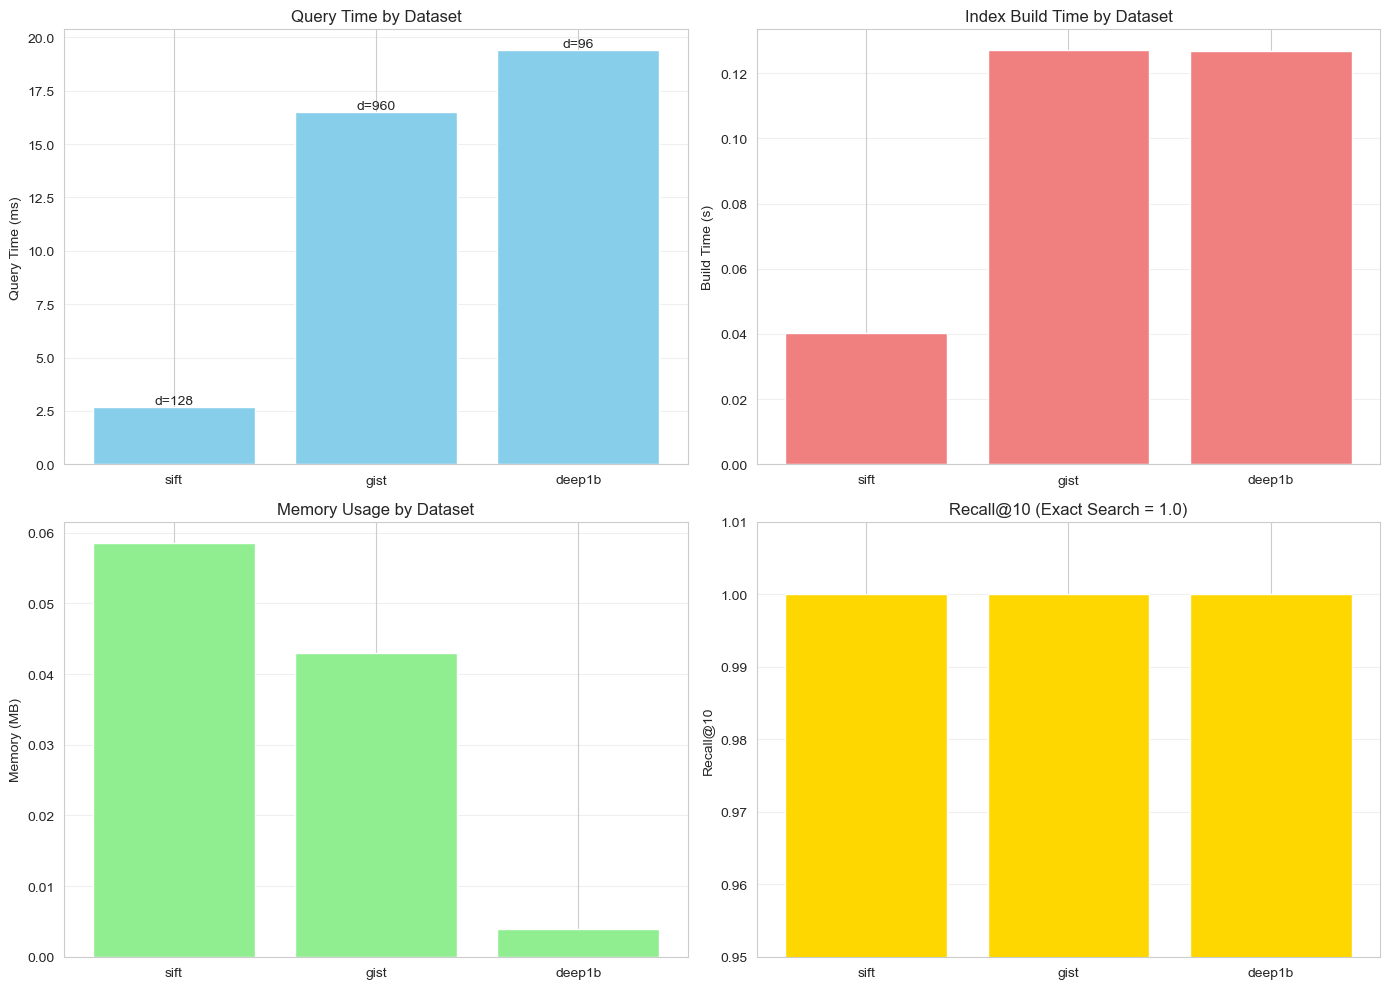


Plot saved to ../results/baseline_knn_comparison.png


In [6]:
if not all_results:
    print("No results to visualize.")
else:
    # Extract data for plotting
    datasets = [r['dataset'] for r in all_results]
    query_times = [r['avg_query_time_ms'] for r in all_results]
    build_times = [r['build_time_s'] for r in all_results]
    memories = [r['memory_mb'] for r in all_results]
    recalls = [r['recall@k'] for r in all_results]
    dimensions = [r['d'] for r in all_results]
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Query time vs dimension
    axes[0, 0].bar(datasets, query_times, color='skyblue')
    axes[0, 0].set_ylabel('Query Time (ms)')
    axes[0, 0].set_title('Query Time by Dataset')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Add dimension labels
    for i, (d, qt) in enumerate(zip(datasets, query_times)):
        axes[0, 0].text(i, qt, f"d={dimensions[i]}", ha='center', va='bottom')
    
    # 2. Build time
    axes[0, 1].bar(datasets, build_times, color='lightcoral')
    axes[0, 1].set_ylabel('Build Time (s)')
    axes[0, 1].set_title('Index Build Time by Dataset')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. Memory usage
    axes[1, 0].bar(datasets, memories, color='lightgreen')
    axes[1, 0].set_ylabel('Memory (MB)')
    axes[1, 0].set_title('Memory Usage by Dataset')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 4. Recall (should all be 1.0 for exact search)
    axes[1, 1].bar(datasets, recalls, color='gold')
    axes[1, 1].set_ylabel(f'Recall@{K}')
    axes[1, 1].set_title(f'Recall@{K} (Exact Search = 1.0)')
    axes[1, 1].set_ylim([0.95, 1.01])
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'baseline_knn_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nPlot saved to {os.path.join(RESULTS_DIR, 'baseline_knn_comparison.png')}")

## 6. Key Observations

**Expected Results:**
- Recall@10 should be exactly 1.0 (brute-force is exact)
- Query time increases with dimension (d)
- GIST (960-dim) should be slowest
- SIFT (128-dim) should be fastest
- Build time should be fast (just stores vectors)

**These baselines establish:**
1. **Upper bound on recall**: 1.0 (perfect)
2. **Lower bound on query time**: What we need to beat with ANN methods
3. **Memory baseline**: Linear storage O(nd)

## 7. Summary Statistics

In [7]:
if all_results:
    print("\nSUMMARY STATISTICS\n")
    print(f"{'Metric':<25} {'Min':<15} {'Max':<15} {'Mean':<15}")
    print("-" * 70)
    
    metrics = {
        'Query Time (ms)': query_times,
        'Build Time (s)': build_times,
        'Memory (MB)': memories,
        'Recall@K': recalls
    }
    
    for metric_name, values in metrics.items():
        print(f"{metric_name:<25} {min(values):<15.3f} {max(values):<15.3f} {np.mean(values):<15.3f}")
    
    # Save summary
    summary = {
        'k': K,
        'n_test': N_TEST,
        'datasets_evaluated': len(all_results),
        'results': all_results
    }
    
    summary_path = os.path.join(RESULTS_DIR, 'baseline_knn_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"\nSummary saved to {summary_path}")


SUMMARY STATISTICS

Metric                    Min             Max             Mean           
----------------------------------------------------------------------
Query Time (ms)           2.675           19.398          12.859         
Build Time (s)            0.040           0.127           0.098          
Memory (MB)               0.004           0.059           0.035          
Recall@K                  1.000           1.000           1.000          

Summary saved to ../results/baseline_knn_summary.json


## Next Steps

1. **JL Projection**: Apply Johnson-Lindenstrauss dimensionality reduction
2. **LSH**: Implement E2LSH for sublinear query time
3. **JL+LSH**: Combine both techniques
4. **Compare**: Evaluate space-time-accuracy trade-offs

All subsequent methods will be compared against these baseline results!